In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.read_open_dataset import DatasetOpenDataset, openDatasetParticipants
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Bad key "text.kerning_factor" on line 4 in
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
datasetName = 'OpenDataset' # PAMAP2 or HAR-UML20 or OpenDataset
EXP_NAME = 'intensity_bias_custom'
CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
FEATURE_SIZE = 32
UMAP_NEIGHTBORS = 20
N_EPOCHS = 2000
RESULTS_PATH = 'results'

In [3]:
participants  = openDatasetParticipants()
participants.describe()
# participants.Genero.value_counts()

# participants.head()

,Id,Edad,Peso,Estatura,Cintura
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,115.517241,44.275862,67.551724,161.724138,89.000000
std,8.958718,15.054417,11.897137,8.297575,10.010709
min,101.000000,20.000000,47.000000,146.000000,65.000000
25%,108.000000,35.000000,61.000000,155.000000,85.000000
50%,116.000000,43.000000,64.000000,165.000000,88.000000
75%,123.000000,59.000000,76.000000,168.000000,96.000000
max,130.000000,73.000000,91.000000,174.000000,108.000000


In [4]:
small_users = participants[participants.Estatura < 155].Id.tolist()

tall_users = participants[participants.Estatura > 170].Id.tolist()

women_users = participants[participants.Genero == 'Femenino '].Id.tolist()

men_users = participants[participants.Genero == 'Masculino '].Id.tolist()

heavy_users = participants[participants.Peso > 80].Id.tolist()

light_users = participants[participants.Peso < 60].Id.tolist()

old_users = participants[participants.Edad < 30].Id.tolist()
young_users = participants[participants.Edad > 70].Id.tolist()

heavy_users = np.array(heavy_users) - 1
light_users = np.array(light_users) - 1
small_users = np.array(small_users) - 1
women_users = np.array(women_users) - 1
men_users = np.array(men_users) - 1
tall_users = np.array(tall_users) - 1
old_users = np.array(old_users) - 1
young_users = np.array(young_users) - 1

fold_names = ['small', 'tall', 'women', 'men', 'light', 'heavy', 'young', 'old']
# print(young_users)
# print(old_users)

In [5]:
# print('Mean age'participants.Edad.mean())
# participants.Id

# print([small_users, tall_users, women_users, men_users, light_users, heavy_users, young_users, old_users])

In [6]:
dataset = DatasetOpenDataset(mode = 'custom', folds = [small_users, tall_users, women_users, men_users, light_users, heavy_users, young_users, old_users])


users = [str(user) for user in dataset.users]
save_name = datasetName + '_' + EXP_NAME
saver = MetricsSaver(save_name, rows = fold_names, cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])
activities = ['caminando;', 'parado;']

In [7]:
predicted_classes = []
real_classes = []
count = 0
while dataset.loadData(activities=activities):
    # Preparing data
    ts_train = TSerie(dataset.X_train, dataset.Int_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test)
    # ts_train.center()
    # ts_test.center()
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()
    
    
    # Getting features
    model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
    ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    ts_test.features = model.transform(ts_test.features)
    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    fold = fold_names[count]
    
    saver.addLog(fold, 'F1-score', test_f1)
    saver.addLog(fold, 'Balanced Accuracy', test_bacc)
    saver.addLog(fold, 'Accuracy', test_acc)
    count = count + 1
    
    
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (35,36,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (36,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (35,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (36,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj

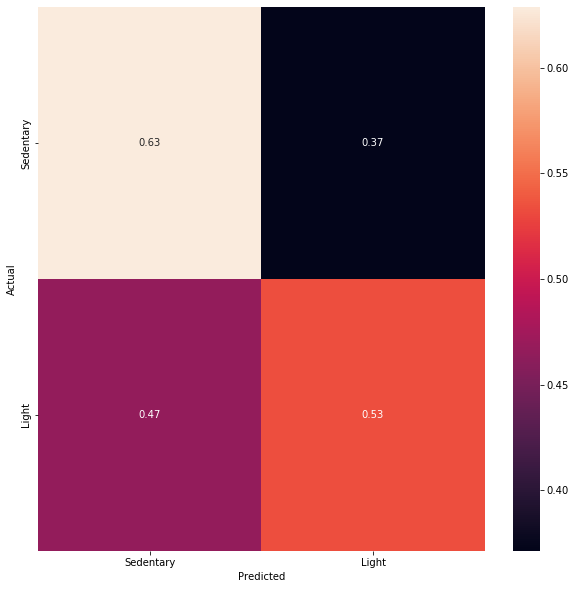

In [8]:

saveConfusionMatrix(real_classes, predicted_classes, save_name, labels=CLASS_LABELS[:2])

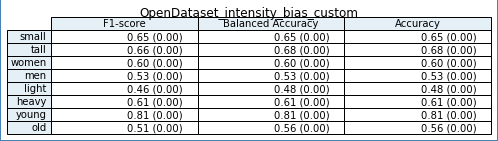

In [9]:
saver.toImage()